# Building our own 2D UNet

Here is an example 2D U-Net implementation using minified data based upon creative commons dataset available at https://wiki.cancerimagingarchive.net/display/Public/HNSCC.

In [ ]:
# RAi, machine learning solutions in radiotherapy
# Copyright (C) 2021-2022 Radiotherapy AI Holdings Pty Ltd

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Affero General Public License as
# published by the Free Software Foundation, either version 3 of the
# License, or (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.

# You should have received a copy of the GNU Affero General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

![full-logo.png](https://raw.githubusercontent.com/RadiotherapyAI/rai/cf28222913602aaab59c3f2d0a0039be2c96e840/notebooks/img/full-logo.png)

# Disclosure of Conflict of Interest

Simon Biggs, the presenter of this workshop owns Radiotherapy AI which is building an open source autocontouring library from which a Medical Device is being built.

## Overview

* Data pipeline
* The pieces of a UNet
* Training the model

### Library imports

Here are a set of library imports, from both the standard library and some libraries downloadable from PyPI. These are imported within namespaces so as not to variable and function name conflicts.

In [1]:
import pathlib
import random
import shutil
import urllib.request

import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

### Constants

In [2]:
BATCH_SIZE = 512
GRID_SIZE = 64

DATASET_TYPES = {"hold-out", "training", "validation"}

COLOURS_AND_LABELS = [
    ("#ff7f0e", "left parotid"),
    ("#2ca02c", "right parotid"),
    ("#d62728", "external"),
]
NUM_CONTOURS = len(COLOURS_AND_LABELS)

In [3]:
IMAGE_DIMENSIONS = (GRID_SIZE, GRID_SIZE, 1)
MASK_DIMENSIONS = (GRID_SIZE, GRID_SIZE, NUM_CONTOURS)

In [4]:
EXPECTED_BATCH_IMAGE_DIMENSIONS = (
    BATCH_SIZE,
    *IMAGE_DIMENSIONS,
)
EXPECTED_BATCH_MASK_DIMENSIONS = (
    BATCH_SIZE,
    *MASK_DIMENSIONS,
)

### Download and investigate the data

In [5]:
zip_url = (
    "https://github.com/RadiotherapyAI/"
    "unet-workshop/releases/download/"
    "mini-parotid/mini-parotid.zip"
)
zip_url

'https://github.com/RadiotherapyAI/unet-workshop/releases/download/mini-parotid/mini-parotid.zip'

In [6]:
# Investigate the downloadable data within a filebrowser

In [7]:
zip_filepath = "data/hnscc.zip"

data_directory = pathlib.Path("data/hnscc")

if not data_directory.exists():
    data_directory.mkdir(parents=True)
    urllib.request.urlretrieve(zip_url, zip_filepath)
    shutil.unpack_archive(zip_filepath, data_directory)

In [8]:
dataset_types_found = {
    path.name
    for path in data_directory.glob("*")
    if path.is_dir()
}

assert dataset_types_found == DATASET_TYPES

### Build the TensorFlow pipeline

In [9]:
def get_image_paths(dataset_type):
    image_paths = list(
        (data_directory / dataset_type).glob(
            "*/*.image.png"
        )
    )

    return image_paths

In [10]:
def get_path_pairs(dataset_type):
    image_paths = get_image_paths(dataset_type)
    mask_paths = [
        path.parent / f"{path.name.split('.')[0]}.masks.png"
        for path in image_paths
    ]

    path_pairs = [
        (str(image), str(mask))
        for image, mask in zip(
            image_paths,
            mask_paths,
        )
    ]

    return sorted(path_pairs)

In [11]:
@tf.function
def load(path_pair):
    image_path = path_pair[0]
    masks_path = path_pair[1]

    image_raw = tf.io.read_file(image_path)
    image = tf.io.decode_image(
        image_raw, channels=1, dtype=tf.uint8
    )

    masks_raw = tf.io.read_file(masks_path)
    masks = tf.io.decode_image(
        masks_raw, channels=NUM_CONTOURS, dtype=tf.uint8
    )

    return image / 255, masks / 255

In [12]:
def create_datasets(dataset_type):
    path_pairs = get_path_pairs(dataset_type)
    dataset = tf.data.Dataset.from_tensor_slices(path_pairs)
    dataset = dataset.shuffle(
        len(path_pairs),
        reshuffle_each_iteration=True,
    )
    dataset = dataset.map(load)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [13]:
datasets = {}

for dataset_type in DATASET_TYPES:
    datasets[dataset_type] = create_datasets(dataset_type)

datasets

{'validation': <PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>,
 'training': <PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>,
 'hold-out': <PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>}

### Plotting the pipeline

In [15]:
iterator = iter(datasets["validation"])

In [16]:
batch_validation_images, batch_validation_masks = next(iterator)

In [17]:
batch_validation_images.shape # image slices (random), columns/rows (colours)

TensorShape([512, 64, 64, 1])

In [18]:
batch_validation_masks.shape

TensorShape([512, 64, 64, 3])

In [40]:
image = batch_validation_images[0, ...]
masks = batch_validation_masks[0, ...]

In [41]:
image.shape

TensorShape([64, 64, 1])

In [42]:
masks.shape

TensorShape([64, 64, 3])

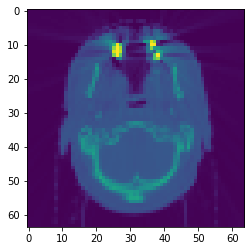

In [43]:
plt.imshow(image[:, :, 0])

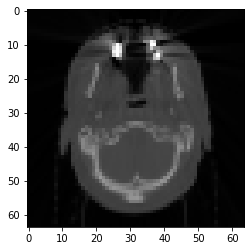

In [44]:
plt.imshow(image[:, :, 0], cmap='gray')

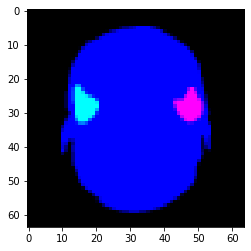

In [45]:
plt.imshow(masks)

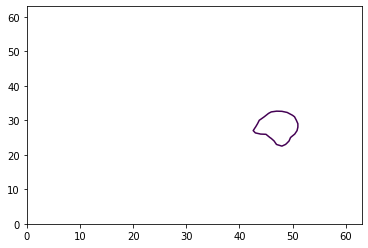

In [46]:
plt.contour(masks[..., 0], levels=[0.5])

(-0.5, 63.5, 63.5, -0.5)

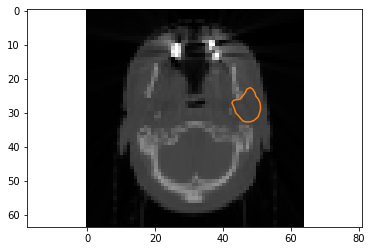

In [47]:
plt.imshow(image[:, :, 0], cmap='gray')
plt.contour(masks[..., 0], levels=[0.5], colors=[COLOURS_AND_LABELS[0][0]])
plt.axis('equal')

(-0.5, 63.5, 63.5, -0.5)

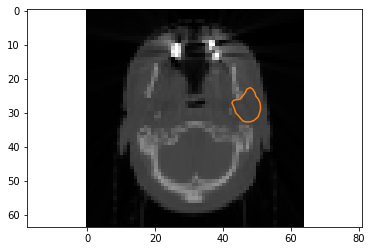

In [48]:
# Try and generalise the above, and see if I can get the same result

i = 0

plt.imshow(image[:, :, 0], cmap='gray')
plt.contour(masks[..., i], levels=[0.5], colors=[COLOURS_AND_LABELS[i][0]])
plt.axis('equal')

(-0.5, 63.5, 63.5, -0.5)

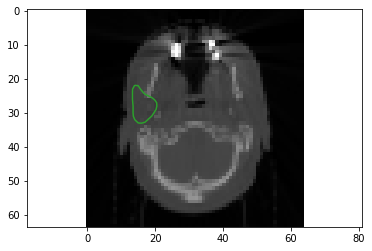

In [28]:
i = 1

plt.imshow(image[:, :, 0], cmap='gray')
plt.contour(masks[..., i], levels=[0.5], colors=[COLOURS_AND_LABELS[i][0]])
plt.axis('equal')

(-0.5, 63.5, 63.5, -0.5)

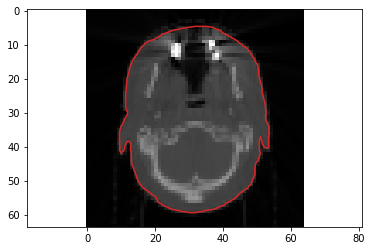

In [29]:
i = 2

plt.imshow(image[:, :, 0], cmap='gray')
plt.contour(masks[..., i], levels=[0.5], colors=[COLOURS_AND_LABELS[i][0]])
plt.axis('equal')

In [30]:
# Turn this into a re-usable function

def plot_contours(ax, image, masks):
    ax.imshow(image[:, :, 0], cmap="gray")

    for i, (colour, label) in enumerate(COLOURS_AND_LABELS):
        if np.all(masks[..., i] < 0.5) or np.all(
            masks[..., i] > 0.5
        ):
            continue

        c = ax.contour(
            masks[..., i],
            colors=[colour],
            levels=[0.5],
        )
        c.collections[0].set_label(label)

    ax.axis("equal")
    ax.legend()

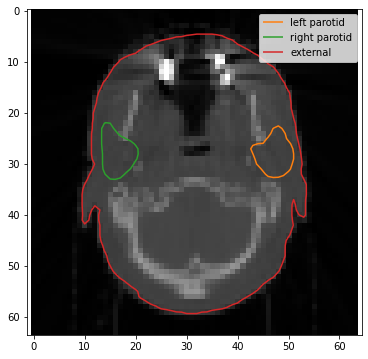

In [49]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_contours(ax, image, masks)

### UNet Diagram

In this section we will create a Tensorflow Keras 2D UNet model utilising a set of pre-built functions. An example UNet diagram is given below for aiding explanation:

![](https://github.com/RadiotherapyAI/unet-workshop/blob/019f25013030e51b83e2370b347bf5933aebc37c/images/unet.png?raw=1)

### Activation

In [50]:
def activation(x):
    x = tf.keras.layers.Activation("relu")(x)

    return x

In [51]:
activation(10).numpy()

10

In [52]:
activation(-5).numpy()

0

Text(0.5, 1.0, 'Relu Activiation')

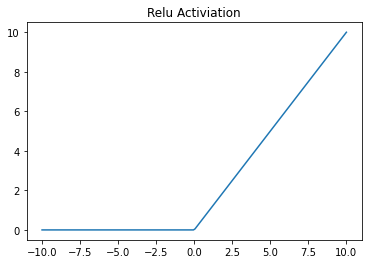

In [53]:
x = np.linspace(-10, 10, 200)
y = activation(x).numpy()

plt.plot(x, y)
plt.title('Relu Activiation')

"A large number of linear combinations of linear equations, can be reduced to a single linear equation".

RELU "breaks" the linearity. And enables "deep" learning.

### Convolution

In [90]:
def array_image(array, vmin=-1, vmax=1):
    plt.imshow(array, vmin=vmin, vmax=vmax)

    for (j,i), label in np.ndenumerate(array):
        plt.text(i, j, np.round(label, decimals=2), ha='center', va='center')
        
    plt.colorbar()

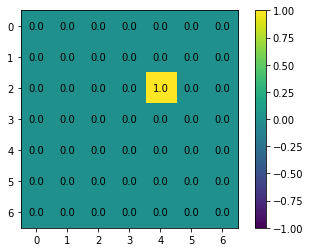

In [91]:
x = np.zeros(shape=(1,7,7,1))
x[0,2,4,0] = 1

array_image(x[0, :, :, 0])

In [92]:
example_convolution = tf.keras.layers.Conv2D(
    filters=1,
    kernel_size=3,
    padding="same",
    kernel_initializer="he_normal",
)

In [93]:
y = example_convolution(x)

In [94]:
# Kernel
example_convolution.weights[0].shape

TensorShape([3, 3, 1, 1])

In [95]:
# Bias
example_convolution.weights[1].shape

TensorShape([1])

In [ ]:
kernel = example_convolution.weights[0][..., 0, 0]
array_image(kernel)

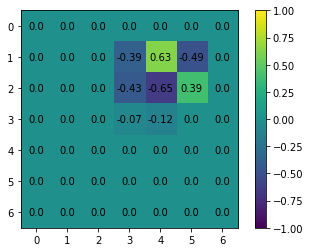

In [99]:
array_image(y[0,...,0])

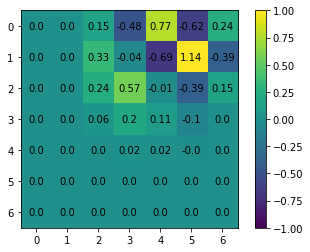

In [100]:
z = example_convolution(y).numpy()
array_image(z[0,...,0])

### Pooling

In [101]:
example_max_pool = tf.keras.layers.MaxPool2D()

In [102]:
z.shape

(1, 7, 7, 1)

In [103]:
pooled_z = example_max_pool(z).numpy()

In [104]:
pooled_z.shape

(1, 3, 3, 1)

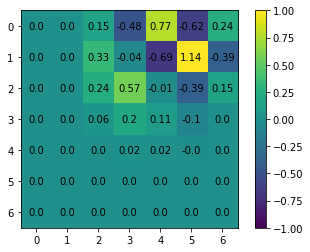

In [105]:
array_image(z[0,...,0])

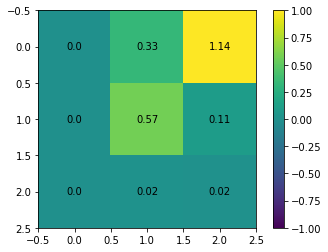

In [106]:
array_image(pooled_z[0,...,0])

### Convolutional Transpose

In [107]:
example_convolution_transpose = tf.keras.layers.Conv2DTranspose(
    filters=1,
    kernel_size=3,
    strides=2,
    padding="same",
    kernel_initializer="he_normal",
)

In [108]:
x.shape

(1, 7, 7, 1)

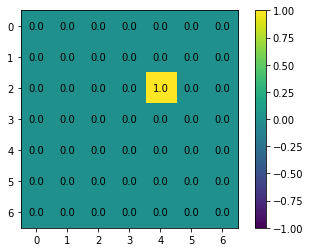

In [109]:
array_image(x[0, ..., 0])

In [110]:
y = example_convolution_transpose(x).numpy()

In [111]:
y.shape

(1, 14, 14, 1)

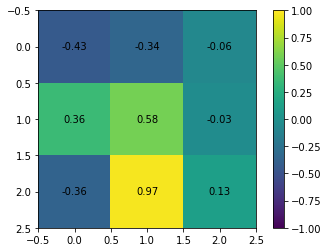

In [112]:
kernel = example_convolution_transpose.weights[0][..., 0, 0]
array_image(kernel)

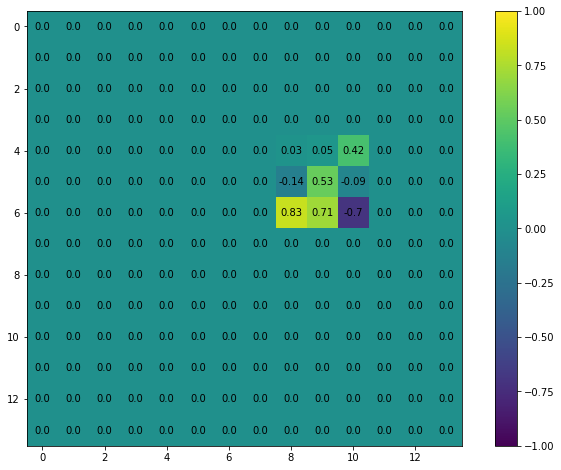

In [82]:
plt.figure(figsize=(12, 8))
array_image(y[0, ..., 0])

### Putting it all together

In [76]:
def convolution(x, number_of_filters, kernel_size=3):
    x = tf.keras.layers.Conv2D(
        number_of_filters,
        kernel_size,
        padding="same",
        kernel_initializer="he_normal",
    )(x)

    return x



def conv_transpose(x, number_of_filters, kernel_size=3):
    x = tf.keras.layers.Conv2DTranspose(
        number_of_filters,
        kernel_size,
        strides=2,
        padding="same",
        kernel_initializer="he_normal",
    )(x)

    return x

In [77]:
def encode(
    x,
    number_of_filters,
    number_of_convolutions=2,
):
    """An encoding layer within a 2D UNet"""
    for _ in range(number_of_convolutions):
        x = convolution(x, number_of_filters)
        x = activation(x)
    skip = x

    x = tf.keras.layers.MaxPool2D()(x)
    x = activation(x)

    return x, skip


def decode(
    x,
    skip,
    number_of_filters,
    number_of_convolutions=2,
):
    """A decoding layer within a 2D UNet"""
    x = conv_transpose(x, number_of_filters)
    x = activation(x)

    x = tf.keras.layers.concatenate([skip, x], axis=-1)

    for _ in range(number_of_convolutions):
        x = convolution(x, number_of_filters)
        x = activation(x)

    return x

In [78]:
def get_unet_filter_counts(grid_size):
    """Return a reasonable set of convolution filter sizes for a UNet"""
    network_depth = int(np.log2(grid_size / 8))
    encoding_filter_counts = 2 ** (
        np.array(range(network_depth)) + 5
    )
    decoding_filter_counts = (
        2 ** (np.array(range(network_depth)) + 6)[::-1]
    )

    return (
        encoding_filter_counts,
        decoding_filter_counts,
    )

In [79]:
def unet(grid_size, num_contours):
    """Create a bare-bones 2D UNet"""
    inputs = tf.keras.layers.Input(
        (grid_size, grid_size, 1)
    )

    (
        encoding_filter_counts,
        decoding_filter_counts,
    ) = get_unet_filter_counts(grid_size)

    x = inputs
    skips = []

    for number_of_filters in encoding_filter_counts:
        x, skip = encode(x, number_of_filters)
        skips.append(skip)

    skips.reverse()

    for number_of_filters, skip in zip(
        decoding_filter_counts, skips
    ):
        x = decode(x, skip, number_of_filters)

    x = tf.keras.layers.Conv2D(
        num_contours,
        1,
        activation="sigmoid",
        padding="same",
        kernel_initializer="he_normal",
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model

In [80]:
model = unet(GRID_SIZE, NUM_CONTOURS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   320         ['input_1[0][0]']                
                                                                                                  
 activation_3 (Activation)      (None, 64, 64, 32)   0           ['conv2d_1[0][0]']               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 64, 32)   9248        ['activation_3[0][0]']           
                                                                                              

### Model loss (binary cross entropy)

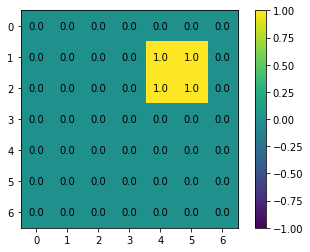

In [113]:
gt = np.zeros(shape=(1,7,7,1))
gt[0,1:3,4:6,0] = 1

array_image(gt[0, ..., 0])

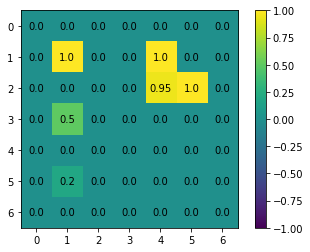

In [114]:
pd = np.copy(gt)
pd[0,2,4,0] = 0.95
pd[0,1,5,0] = 0
pd[0,5,1,0] = 0.2
pd[0,3,1,0] = 0.5
pd[0,1,1,0] = 1

array_image(pd[0, ..., 0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


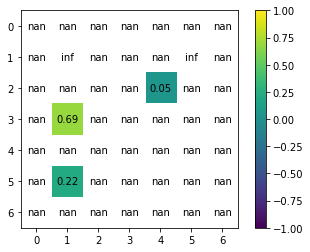

In [115]:
bce = -(gt * np.log(pd) + (1 - gt) * np.log(1 - pd))
array_image(bce[0, ..., 0])

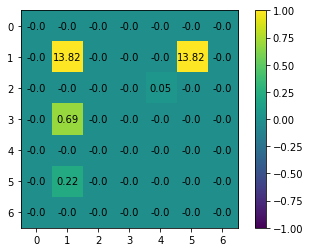

In [116]:
epsilon = 0.000001 # Add this to avoid nan (above)

bce = -(gt * np.log(pd + epsilon) + (1 - gt) * np.log(1 - pd + epsilon))
array_image(bce[0, ..., 0])

In [117]:
loss = np.sum(bce)
loss

28.598556839584013

### The model prior to training

In [118]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
    ],
)

In [119]:
image.shape

TensorShape([64, 64, 1])

In [120]:
pred_masks = model.predict(image[None, ...])[0, ...]

1/1 [==============================] - 1s 687ms/step


In [121]:
masks.shape

TensorShape([64, 64, 3])

In [122]:
pred_masks.shape

(64, 64, 3)

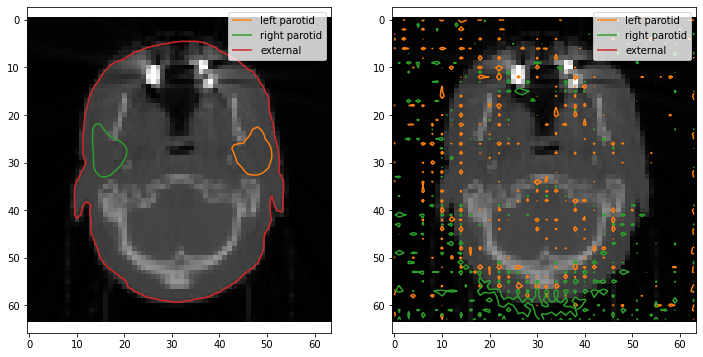

In [123]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
plot_contours(ax[0], image, masks) # GT
plot_contours(ax[1], image, pred_masks) # What the model predicts

In [124]:
def plot_with_prediction(image, masks, pred_masks):
    fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
    plot_contours(ax[0], image, masks)
    plot_contours(ax[1], image, pred_masks)

In [125]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        pred_masks = model.predict(image[None, ...])[0, ...]
        plot_with_prediction(image, masks, pred_masks)

        plt.show()
        print(
            "\nSample Prediction after"
            " epoch {}\n".format(epoch + 1)
        )

1/1 [==============================] - 0s 16ms/step


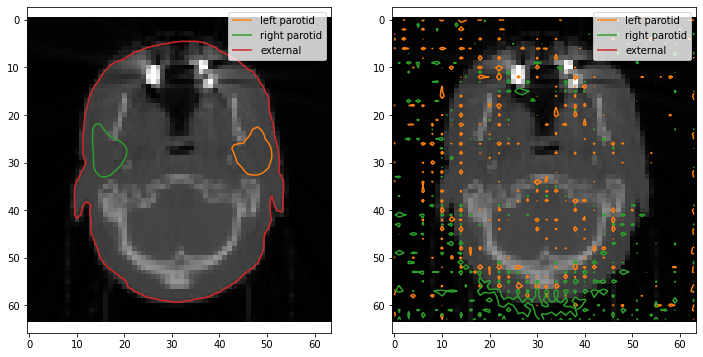


Sample Prediction after epoch 10001



In [126]:
callback = DisplayCallback()
callback.on_epoch_end(10000)

### Training the model

Epoch 1/50
1/1 [==============================] - 0s 21ms/step


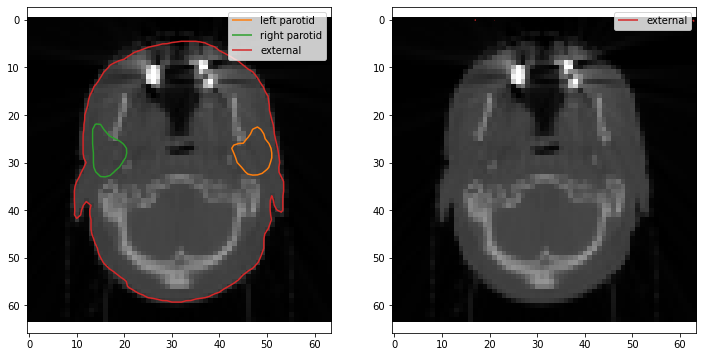


Sample Prediction after epoch 1

4/4 [==============================] - 34s 5s/step - loss: 0.5835 - binary_accuracy: 0.8242 - recall: 0.2998 - precision: 0.3806 - val_loss: 0.3754 - val_binary_accuracy: 0.7821 - val_recall: 0.9488 - val_precision: 0.4076
Epoch 2/50
1/1 [==============================] - 0s 17ms/step


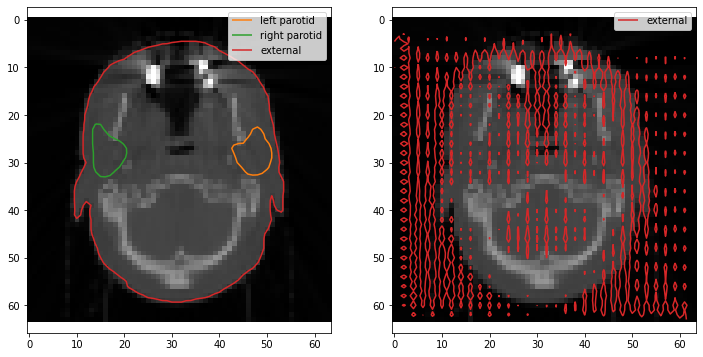


Sample Prediction after epoch 2

4/4 [==============================] - 5s 1s/step - loss: 0.3343 - binary_accuracy: 0.7910 - recall: 0.9488 - precision: 0.4215 - val_loss: 0.2888 - val_binary_accuracy: 0.8896 - val_recall: 0.7764 - val_precision: 0.6138
Epoch 3/50
1/1 [==============================] - 0s 17ms/step


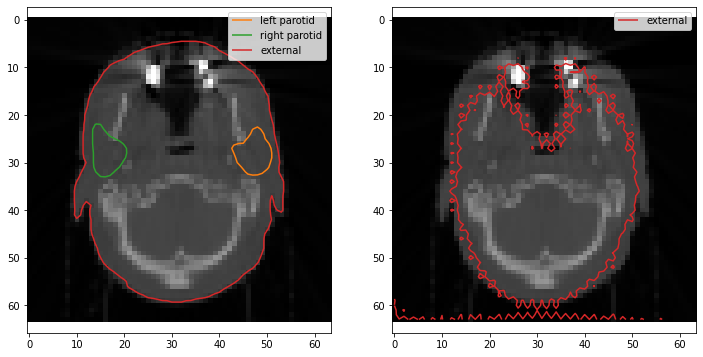


Sample Prediction after epoch 3

4/4 [==============================] - 5s 1s/step - loss: 0.2648 - binary_accuracy: 0.9136 - recall: 0.6351 - precision: 0.7614 - val_loss: 0.1914 - val_binary_accuracy: 0.9606 - val_recall: 0.7796 - val_precision: 0.9547
Epoch 4/50
1/1 [==============================] - 0s 16ms/step


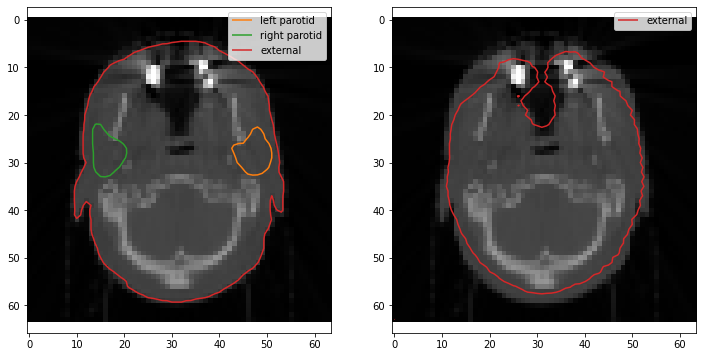


Sample Prediction after epoch 4

4/4 [==============================] - 5s 1s/step - loss: 0.1545 - binary_accuracy: 0.9649 - recall: 0.7990 - precision: 0.9769 - val_loss: 0.0871 - val_binary_accuracy: 0.9727 - val_recall: 0.8343 - val_precision: 0.9945
Epoch 5/50
1/1 [==============================] - 0s 16ms/step


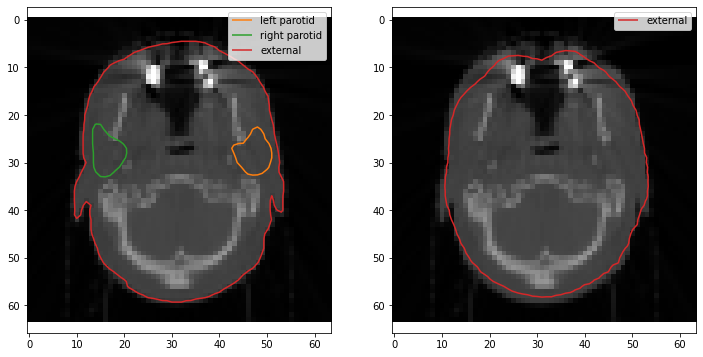


Sample Prediction after epoch 5

4/4 [==============================] - 5s 1s/step - loss: 0.0766 - binary_accuracy: 0.9739 - recall: 0.8825 - precision: 0.9829 - val_loss: 0.0577 - val_binary_accuracy: 0.9762 - val_recall: 0.8759 - val_precision: 0.9905
Epoch 6/50
1/1 [==============================] - 0s 20ms/step


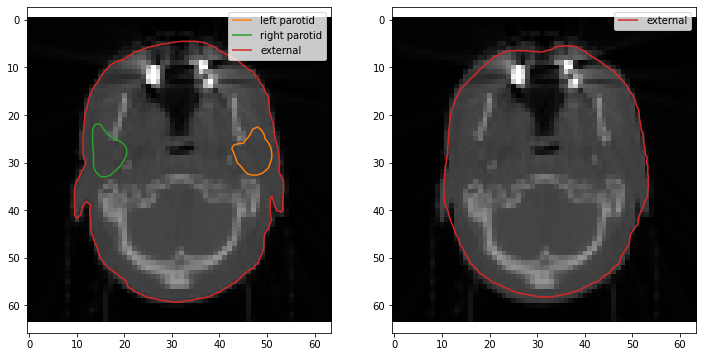


Sample Prediction after epoch 6

4/4 [==============================] - 5s 1s/step - loss: 0.0553 - binary_accuracy: 0.9755 - recall: 0.9029 - precision: 0.9813 - val_loss: 0.0484 - val_binary_accuracy: 0.9773 - val_recall: 0.9055 - val_precision: 0.9874
Epoch 7/50
1/1 [==============================] - 0s 21ms/step


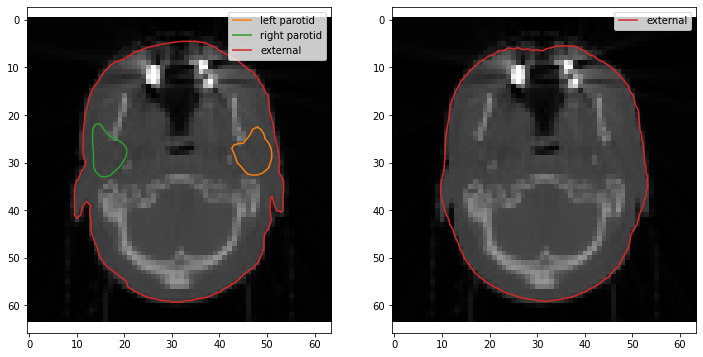


Sample Prediction after epoch 7

4/4 [==============================] - 5s 1s/step - loss: 0.0483 - binary_accuracy: 0.9769 - recall: 0.9071 - precision: 0.9880 - val_loss: 0.0474 - val_binary_accuracy: 0.9768 - val_recall: 0.9238 - val_precision: 0.9819
Epoch 8/50
1/1 [==============================] - 0s 16ms/step


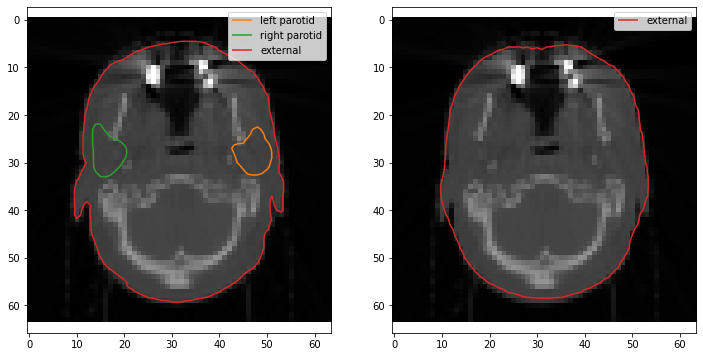


Sample Prediction after epoch 8

4/4 [==============================] - 5s 1s/step - loss: 0.0462 - binary_accuracy: 0.9772 - recall: 0.9079 - precision: 0.9899 - val_loss: 0.0452 - val_binary_accuracy: 0.9774 - val_recall: 0.9197 - val_precision: 0.9863
Epoch 9/50
1/1 [==============================] - 0s 16ms/step


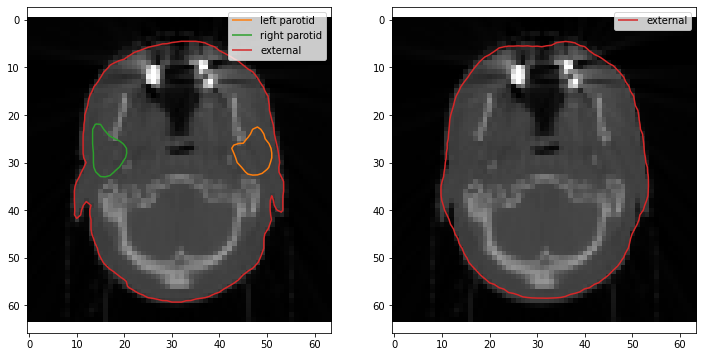


Sample Prediction after epoch 9

4/4 [==============================] - 5s 1s/step - loss: 0.0439 - binary_accuracy: 0.9774 - recall: 0.9033 - precision: 0.9918 - val_loss: 0.0420 - val_binary_accuracy: 0.9777 - val_recall: 0.9113 - val_precision: 0.9894
Epoch 10/50
1/1 [==============================] - 0s 16ms/step


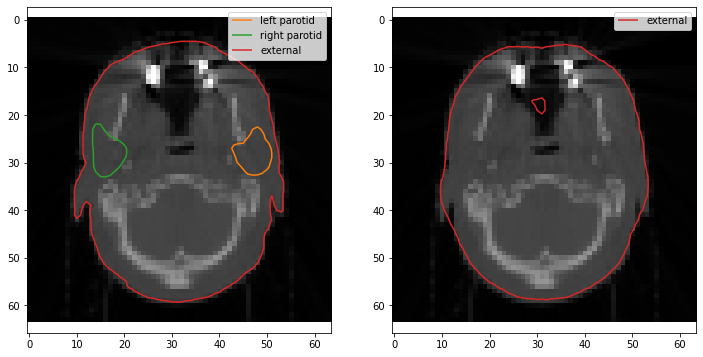


Sample Prediction after epoch 10

4/4 [==============================] - 5s 1s/step - loss: 0.0412 - binary_accuracy: 0.9775 - recall: 0.9036 - precision: 0.9921 - val_loss: 0.0400 - val_binary_accuracy: 0.9780 - val_recall: 0.9009 - val_precision: 0.9922
Epoch 11/50
1/1 [==============================] - 0s 17ms/step


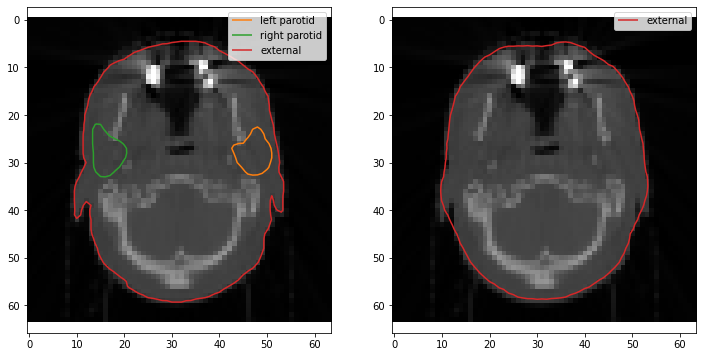


Sample Prediction after epoch 11

4/4 [==============================] - 5s 1s/step - loss: 0.0394 - binary_accuracy: 0.9777 - recall: 0.9027 - precision: 0.9933 - val_loss: 0.0385 - val_binary_accuracy: 0.9782 - val_recall: 0.9017 - val_precision: 0.9933
Epoch 12/50
1/1 [==============================] - 0s 18ms/step


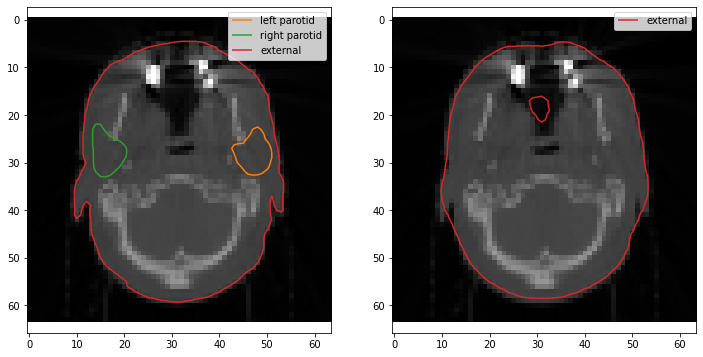


Sample Prediction after epoch 12

4/4 [==============================] - 5s 1s/step - loss: 0.0380 - binary_accuracy: 0.9778 - recall: 0.9023 - precision: 0.9941 - val_loss: 0.0373 - val_binary_accuracy: 0.9782 - val_recall: 0.9014 - val_precision: 0.9938
Epoch 13/50
1/1 [==============================] - 0s 17ms/step


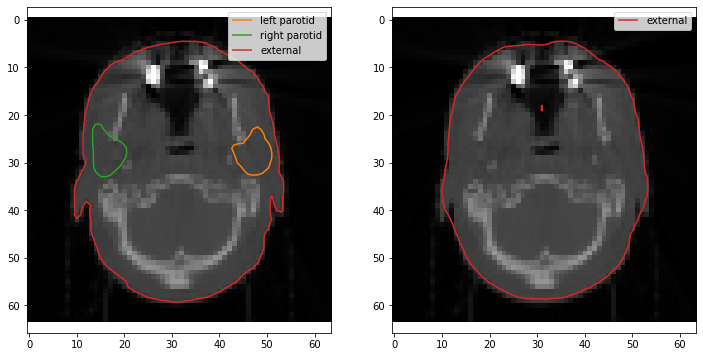


Sample Prediction after epoch 13

4/4 [==============================] - 5s 1s/step - loss: 0.0366 - binary_accuracy: 0.9779 - recall: 0.9030 - precision: 0.9944 - val_loss: 0.0358 - val_binary_accuracy: 0.9784 - val_recall: 0.9020 - val_precision: 0.9944
Epoch 14/50
1/1 [==============================] - 0s 16ms/step


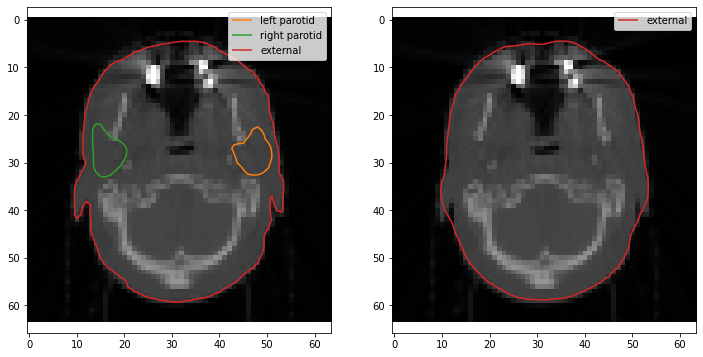


Sample Prediction after epoch 14

4/4 [==============================] - 5s 1s/step - loss: 0.0351 - binary_accuracy: 0.9780 - recall: 0.9028 - precision: 0.9950 - val_loss: 0.0342 - val_binary_accuracy: 0.9784 - val_recall: 0.9098 - val_precision: 0.9937
Epoch 15/50
1/1 [==============================] - 0s 18ms/step


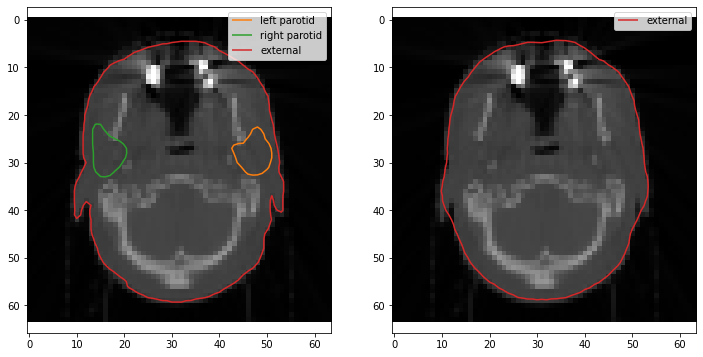


Sample Prediction after epoch 15

4/4 [==============================] - 5s 1s/step - loss: 0.0335 - binary_accuracy: 0.9781 - recall: 0.9038 - precision: 0.9952 - val_loss: 0.0326 - val_binary_accuracy: 0.9786 - val_recall: 0.9020 - val_precision: 0.9951
Epoch 16/50
1/1 [==============================] - 0s 19ms/step


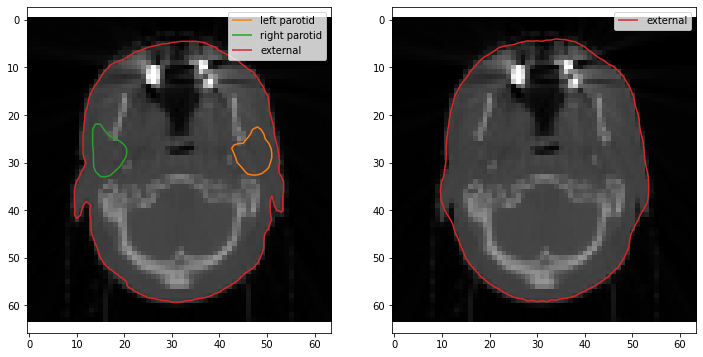


Sample Prediction after epoch 16

4/4 [==============================] - 5s 1s/step - loss: 0.0322 - binary_accuracy: 0.9781 - recall: 0.9025 - precision: 0.9953 - val_loss: 0.0319 - val_binary_accuracy: 0.9785 - val_recall: 0.9157 - val_precision: 0.9932
Epoch 17/50
1/1 [==============================] - 0s 17ms/step


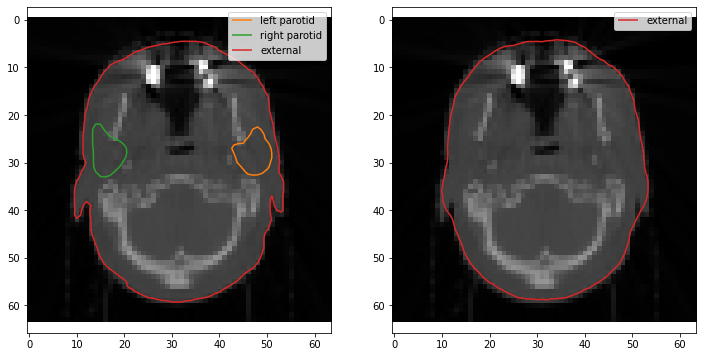


Sample Prediction after epoch 17

4/4 [==============================] - 5s 1s/step - loss: 0.0308 - binary_accuracy: 0.9782 - recall: 0.9047 - precision: 0.9953 - val_loss: 0.0300 - val_binary_accuracy: 0.9787 - val_recall: 0.9002 - val_precision: 0.9957
Epoch 18/50
1/1 [==============================] - 0s 17ms/step


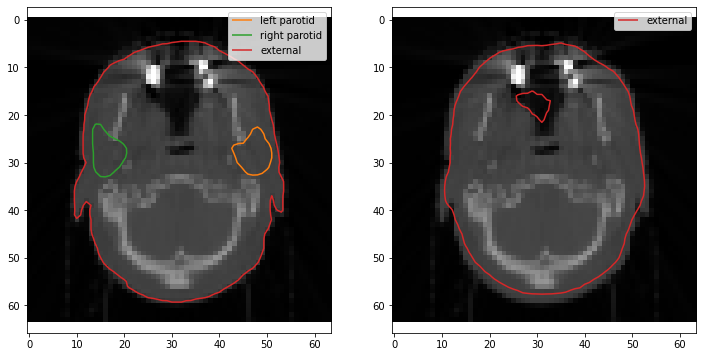


Sample Prediction after epoch 18

4/4 [==============================] - 5s 1s/step - loss: 0.0308 - binary_accuracy: 0.9780 - recall: 0.9025 - precision: 0.9943 - val_loss: 0.0444 - val_binary_accuracy: 0.9760 - val_recall: 0.8435 - val_precision: 0.9983
Epoch 19/50
1/1 [==============================] - 0s 16ms/step


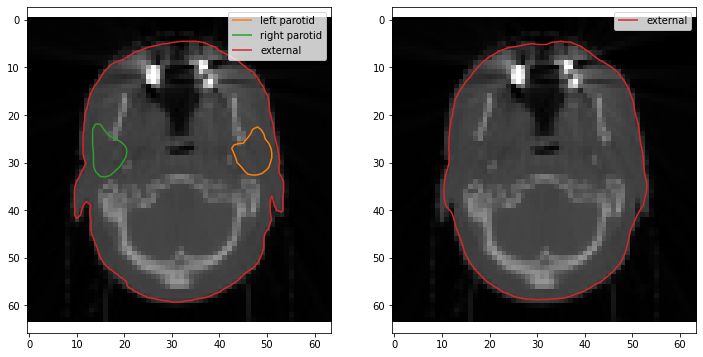


Sample Prediction after epoch 19

4/4 [==============================] - 5s 1s/step - loss: 0.0434 - binary_accuracy: 0.9752 - recall: 0.9031 - precision: 0.9822 - val_loss: 0.0394 - val_binary_accuracy: 0.9787 - val_recall: 0.8943 - val_precision: 0.9969
Epoch 20/50
1/1 [==============================] - 0s 31ms/step


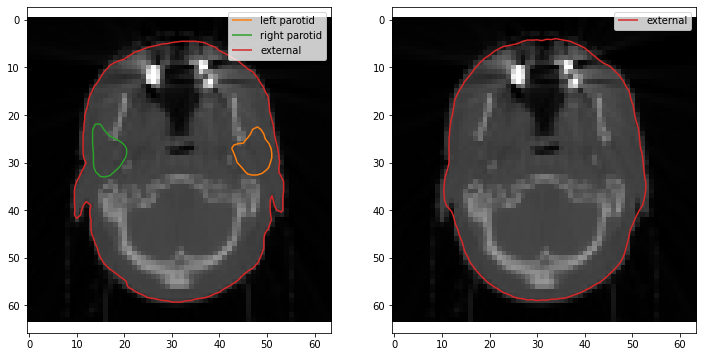


Sample Prediction after epoch 20

4/4 [==============================] - 5s 1s/step - loss: 0.0367 - binary_accuracy: 0.9781 - recall: 0.9035 - precision: 0.9954 - val_loss: 0.0345 - val_binary_accuracy: 0.9787 - val_recall: 0.8958 - val_precision: 0.9965
Epoch 21/50
1/1 [==============================] - 0s 16ms/step


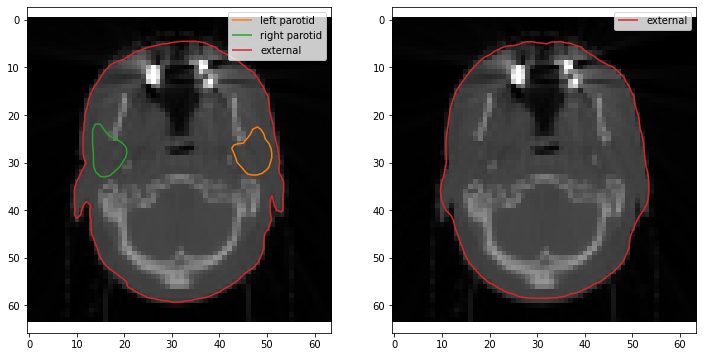


Sample Prediction after epoch 21

4/4 [==============================] - 5s 1s/step - loss: 0.0331 - binary_accuracy: 0.9783 - recall: 0.8954 - precision: 0.9968 - val_loss: 0.0311 - val_binary_accuracy: 0.9786 - val_recall: 0.9122 - val_precision: 0.9948
Epoch 22/50
1/1 [==============================] - 0s 15ms/step


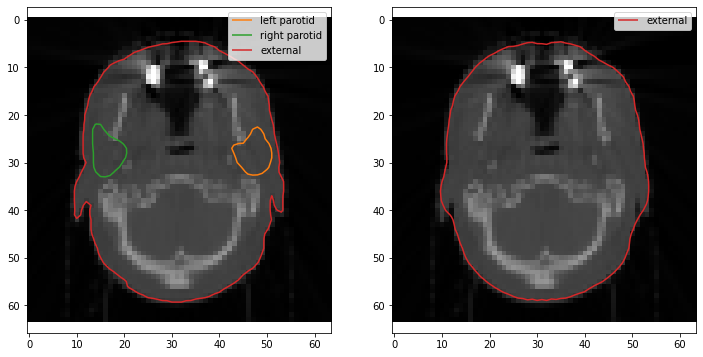


Sample Prediction after epoch 22

4/4 [==============================] - 5s 1s/step - loss: 0.0317 - binary_accuracy: 0.9782 - recall: 0.9036 - precision: 0.9960 - val_loss: 0.0304 - val_binary_accuracy: 0.9787 - val_recall: 0.9119 - val_precision: 0.9951
Epoch 23/50
1/1 [==============================] - 0s 17ms/step


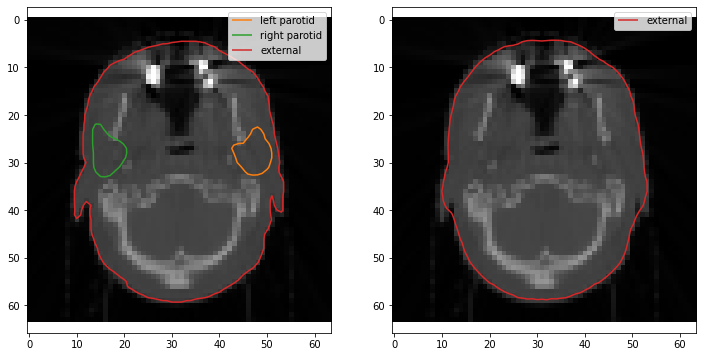


Sample Prediction after epoch 23

4/4 [==============================] - 5s 1s/step - loss: 0.0300 - binary_accuracy: 0.9783 - recall: 0.9052 - precision: 0.9962 - val_loss: 0.0301 - val_binary_accuracy: 0.9788 - val_recall: 0.8988 - val_precision: 0.9966
Epoch 24/50
1/1 [==============================] - 0s 17ms/step


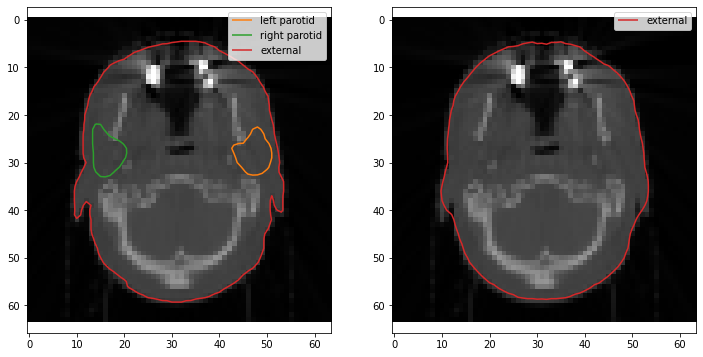


Sample Prediction after epoch 24

4/4 [==============================] - 5s 1s/step - loss: 0.0293 - binary_accuracy: 0.9783 - recall: 0.9017 - precision: 0.9967 - val_loss: 0.0285 - val_binary_accuracy: 0.9788 - val_recall: 0.9001 - val_precision: 0.9965
Epoch 25/50
1/1 [==============================] - 0s 16ms/step


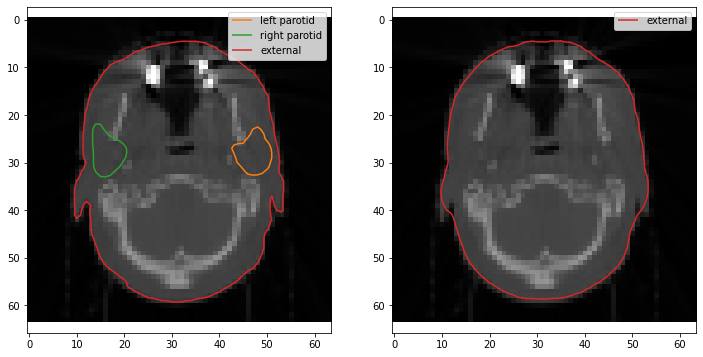


Sample Prediction after epoch 25

4/4 [==============================] - 5s 1s/step - loss: 0.0281 - binary_accuracy: 0.9784 - recall: 0.9030 - precision: 0.9967 - val_loss: 0.0275 - val_binary_accuracy: 0.9789 - val_recall: 0.8990 - val_precision: 0.9969
Epoch 26/50
1/1 [==============================] - 0s 19ms/step


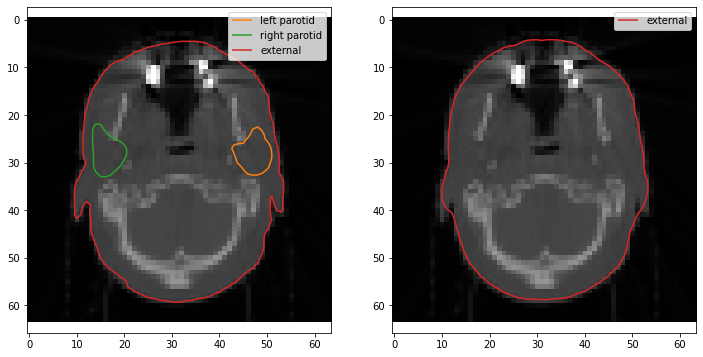


Sample Prediction after epoch 26

4/4 [==============================] - 5s 1s/step - loss: 0.0269 - binary_accuracy: 0.9784 - recall: 0.9005 - precision: 0.9972 - val_loss: 0.0271 - val_binary_accuracy: 0.9789 - val_recall: 0.8982 - val_precision: 0.9971
Epoch 27/50
1/1 [==============================] - 0s 16ms/step


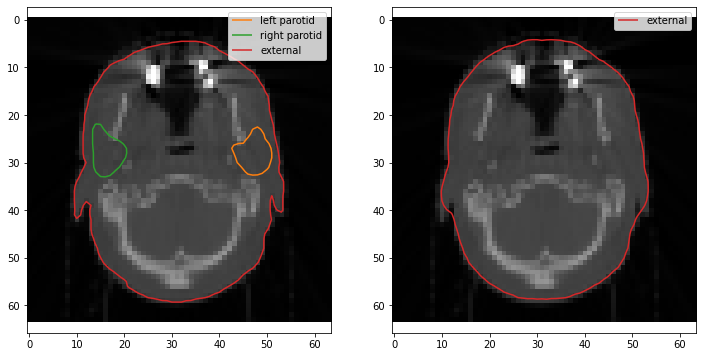


Sample Prediction after epoch 27

4/4 [==============================] - 5s 1s/step - loss: 0.0262 - binary_accuracy: 0.9785 - recall: 0.8996 - precision: 0.9974 - val_loss: 0.0259 - val_binary_accuracy: 0.9789 - val_recall: 0.9012 - val_precision: 0.9970
Epoch 28/50
1/1 [==============================] - 0s 17ms/step


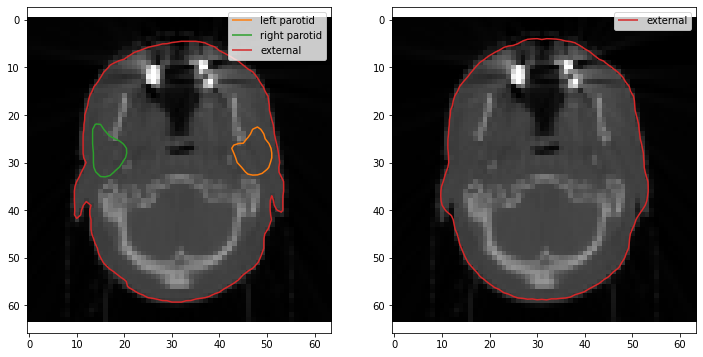


Sample Prediction after epoch 28

4/4 [==============================] - 5s 1s/step - loss: 0.0254 - binary_accuracy: 0.9785 - recall: 0.9011 - precision: 0.9975 - val_loss: 0.0257 - val_binary_accuracy: 0.9789 - val_recall: 0.9058 - val_precision: 0.9967
Epoch 29/50
1/1 [==============================] - 0s 16ms/step


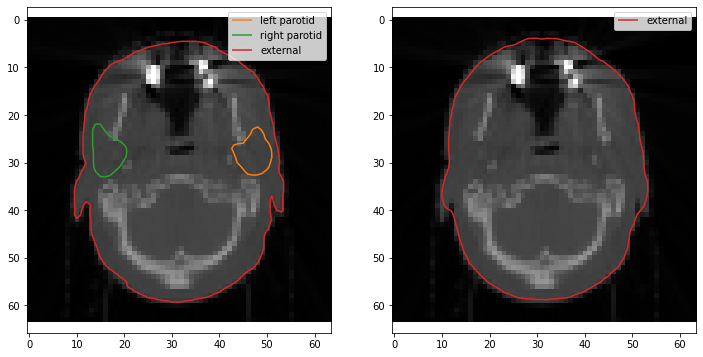


Sample Prediction after epoch 29

4/4 [==============================] - 5s 1s/step - loss: 0.0249 - binary_accuracy: 0.9785 - recall: 0.9008 - precision: 0.9975 - val_loss: 0.0251 - val_binary_accuracy: 0.9790 - val_recall: 0.8959 - val_precision: 0.9976
Epoch 30/50
1/1 [==============================] - 0s 16ms/step


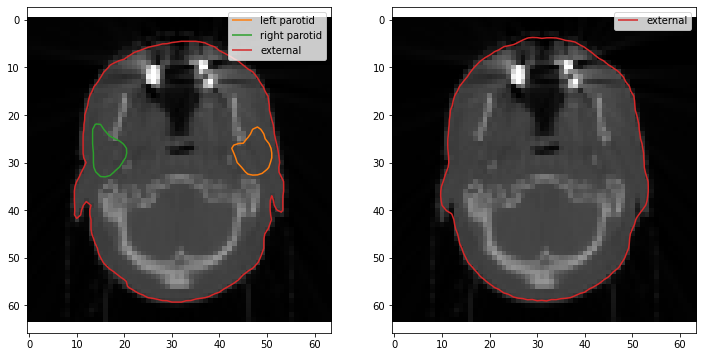


Sample Prediction after epoch 30

4/4 [==============================] - 5s 1s/step - loss: 0.0244 - binary_accuracy: 0.9785 - recall: 0.8989 - precision: 0.9979 - val_loss: 0.0249 - val_binary_accuracy: 0.9789 - val_recall: 0.9080 - val_precision: 0.9969
Epoch 31/50
1/1 [==============================] - 0s 17ms/step


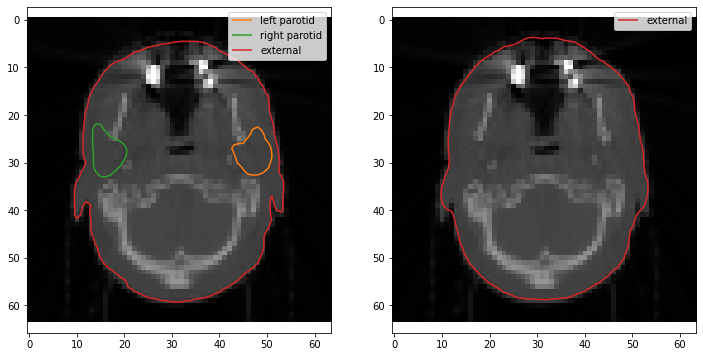


Sample Prediction after epoch 31

4/4 [==============================] - 5s 1s/step - loss: 0.0239 - binary_accuracy: 0.9785 - recall: 0.9014 - precision: 0.9978 - val_loss: 0.0242 - val_binary_accuracy: 0.9790 - val_recall: 0.8976 - val_precision: 0.9978
Epoch 32/50
1/1 [==============================] - 0s 17ms/step


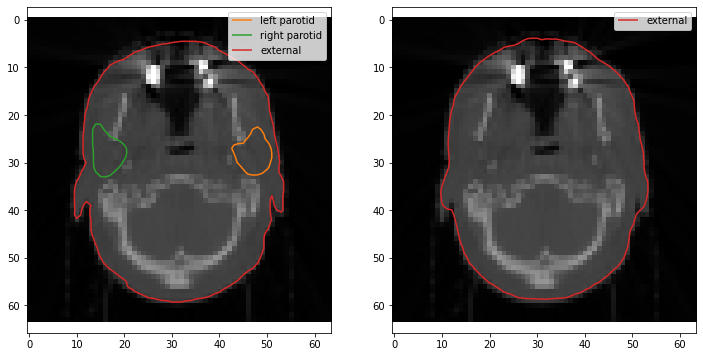


Sample Prediction after epoch 32

4/4 [==============================] - 5s 1s/step - loss: 0.0236 - binary_accuracy: 0.9786 - recall: 0.8995 - precision: 0.9980 - val_loss: 0.0240 - val_binary_accuracy: 0.9790 - val_recall: 0.8930 - val_precision: 0.9980
Epoch 33/50
1/1 [==============================] - 0s 18ms/step


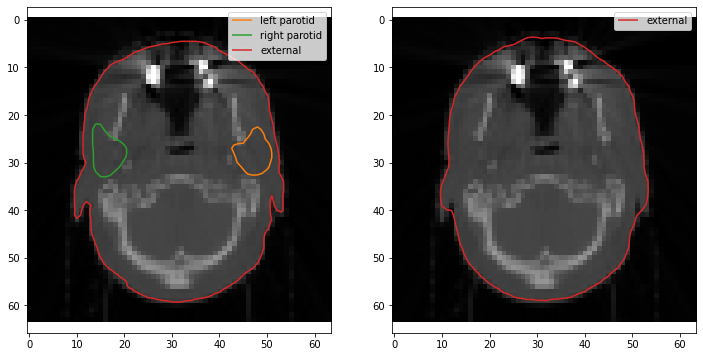


Sample Prediction after epoch 33

4/4 [==============================] - 5s 1s/step - loss: 0.0231 - binary_accuracy: 0.9786 - recall: 0.8989 - precision: 0.9981 - val_loss: 0.0233 - val_binary_accuracy: 0.9790 - val_recall: 0.9023 - val_precision: 0.9977
Epoch 34/50
1/1 [==============================] - 0s 21ms/step


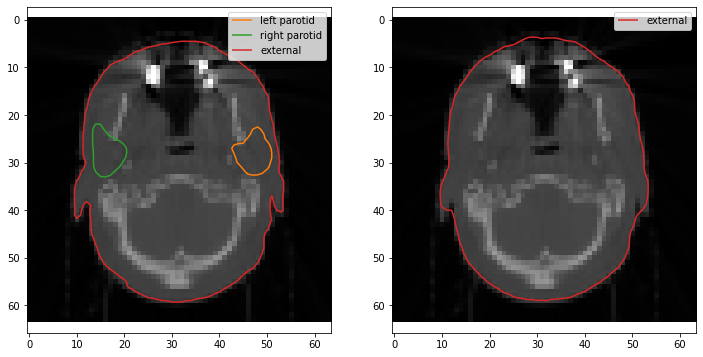


Sample Prediction after epoch 34

4/4 [==============================] - 5s 1s/step - loss: 0.0224 - binary_accuracy: 0.9786 - recall: 0.9007 - precision: 0.9981 - val_loss: 0.0229 - val_binary_accuracy: 0.9790 - val_recall: 0.9030 - val_precision: 0.9976
Epoch 35/50
1/1 [==============================] - 0s 16ms/step


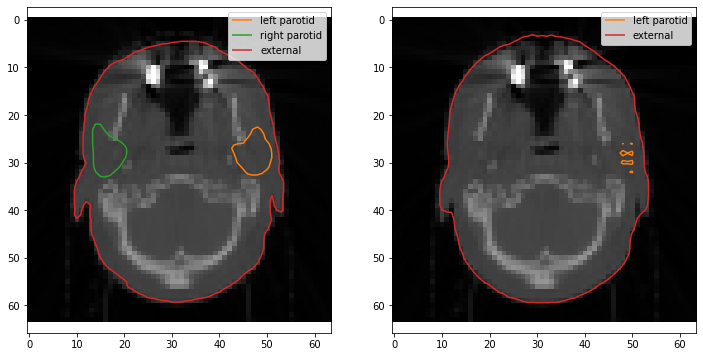


Sample Prediction after epoch 35

4/4 [==============================] - 5s 1s/step - loss: 0.0219 - binary_accuracy: 0.9786 - recall: 0.9006 - precision: 0.9981 - val_loss: 0.0258 - val_binary_accuracy: 0.9787 - val_recall: 0.9253 - val_precision: 0.9945
Epoch 36/50
1/1 [==============================] - 0s 16ms/step


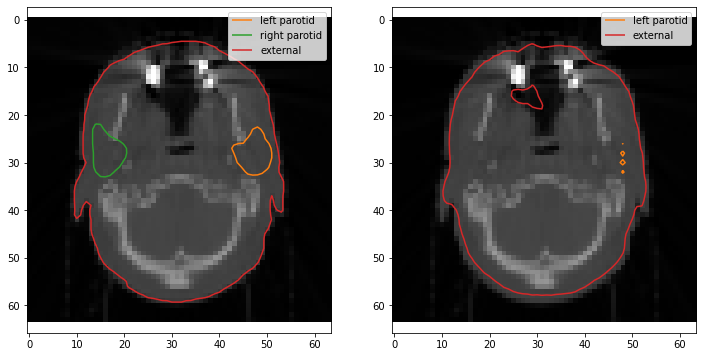


Sample Prediction after epoch 36

4/4 [==============================] - 5s 1s/step - loss: 0.0320 - binary_accuracy: 0.9772 - recall: 0.9107 - precision: 0.9881 - val_loss: 0.0347 - val_binary_accuracy: 0.9766 - val_recall: 0.8470 - val_precision: 0.9991
Epoch 37/50
1/1 [==============================] - 0s 16ms/step


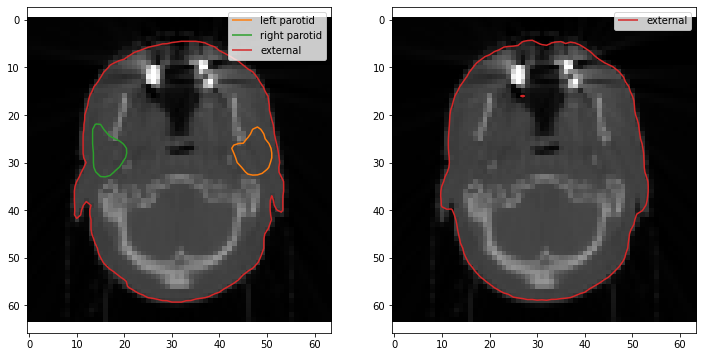


Sample Prediction after epoch 37

4/4 [==============================] - 5s 1s/step - loss: 0.0286 - binary_accuracy: 0.9776 - recall: 0.8962 - precision: 0.9965 - val_loss: 0.0248 - val_binary_accuracy: 0.9788 - val_recall: 0.9060 - val_precision: 0.9978
Epoch 38/50
1/1 [==============================] - 0s 16ms/step


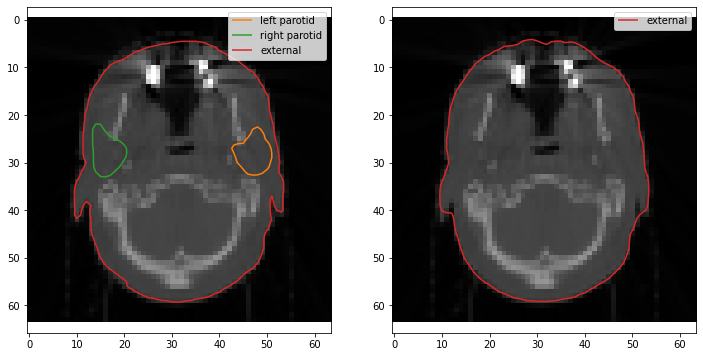


Sample Prediction after epoch 38

4/4 [==============================] - 5s 1s/step - loss: 0.0256 - binary_accuracy: 0.9779 - recall: 0.8859 - precision: 0.9987 - val_loss: 0.0259 - val_binary_accuracy: 0.9788 - val_recall: 0.9198 - val_precision: 0.9959
Epoch 39/50
1/1 [==============================] - 0s 17ms/step


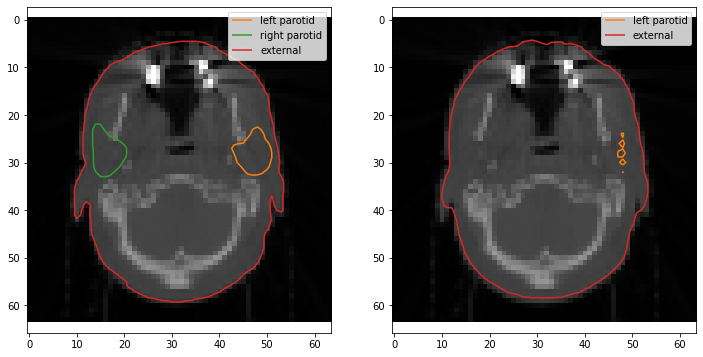


Sample Prediction after epoch 39

4/4 [==============================] - 5s 1s/step - loss: 0.0239 - binary_accuracy: 0.9784 - recall: 0.9107 - precision: 0.9971 - val_loss: 0.0239 - val_binary_accuracy: 0.9791 - val_recall: 0.8871 - val_precision: 0.9980
Epoch 40/50
1/1 [==============================] - 0s 16ms/step


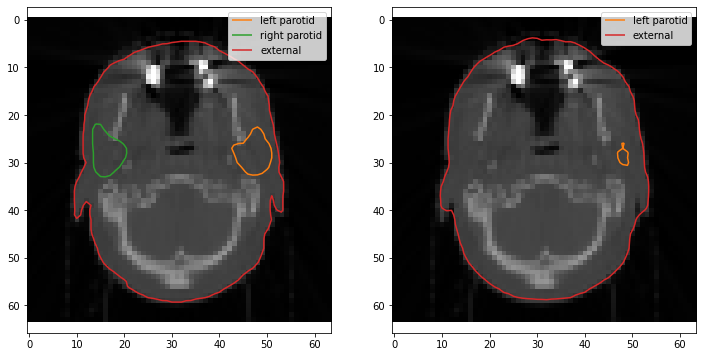


Sample Prediction after epoch 40

4/4 [==============================] - 5s 1s/step - loss: 0.0223 - binary_accuracy: 0.9788 - recall: 0.9014 - precision: 0.9976 - val_loss: 0.0223 - val_binary_accuracy: 0.9791 - val_recall: 0.9088 - val_precision: 0.9971
Epoch 41/50
1/1 [==============================] - 0s 16ms/step


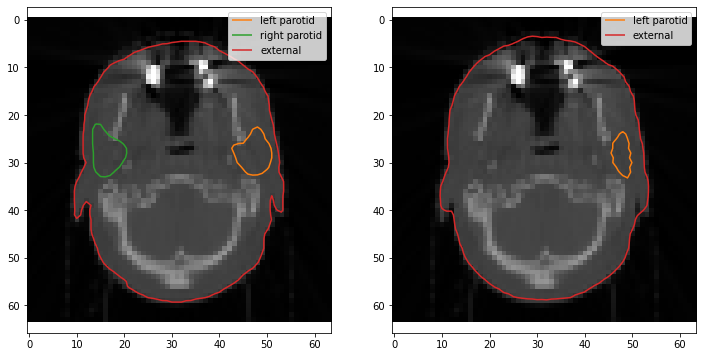


Sample Prediction after epoch 41

4/4 [==============================] - 5s 1s/step - loss: 0.0213 - binary_accuracy: 0.9789 - recall: 0.9008 - precision: 0.9977 - val_loss: 0.0220 - val_binary_accuracy: 0.9794 - val_recall: 0.9174 - val_precision: 0.9954
Epoch 42/50
1/1 [==============================] - 0s 18ms/step


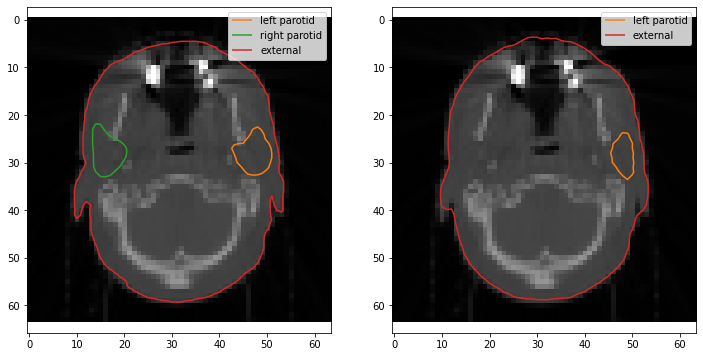


Sample Prediction after epoch 42

4/4 [==============================] - 5s 1s/step - loss: 0.0205 - binary_accuracy: 0.9793 - recall: 0.9115 - precision: 0.9965 - val_loss: 0.0209 - val_binary_accuracy: 0.9796 - val_recall: 0.9068 - val_precision: 0.9958
Epoch 43/50
1/1 [==============================] - 0s 18ms/step


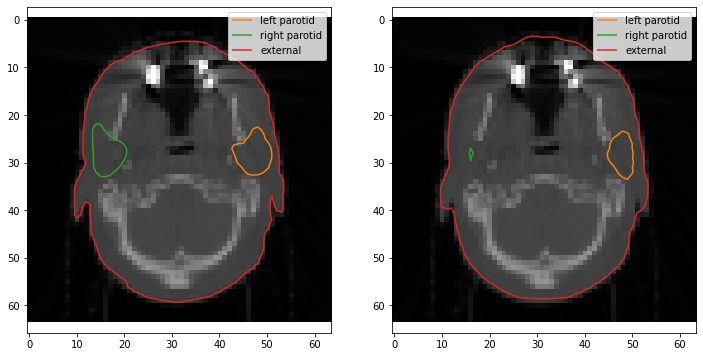


Sample Prediction after epoch 43

4/4 [==============================] - 5s 1s/step - loss: 0.0198 - binary_accuracy: 0.9794 - recall: 0.9130 - precision: 0.9961 - val_loss: 0.0205 - val_binary_accuracy: 0.9797 - val_recall: 0.9062 - val_precision: 0.9945
Epoch 44/50
1/1 [==============================] - 0s 17ms/step


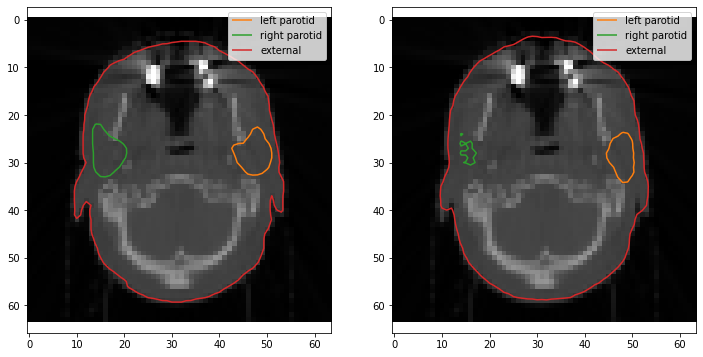


Sample Prediction after epoch 44

4/4 [==============================] - 5s 1s/step - loss: 0.0192 - binary_accuracy: 0.9797 - recall: 0.9132 - precision: 0.9958 - val_loss: 0.0199 - val_binary_accuracy: 0.9800 - val_recall: 0.9138 - val_precision: 0.9939
Epoch 45/50
1/1 [==============================] - 0s 17ms/step


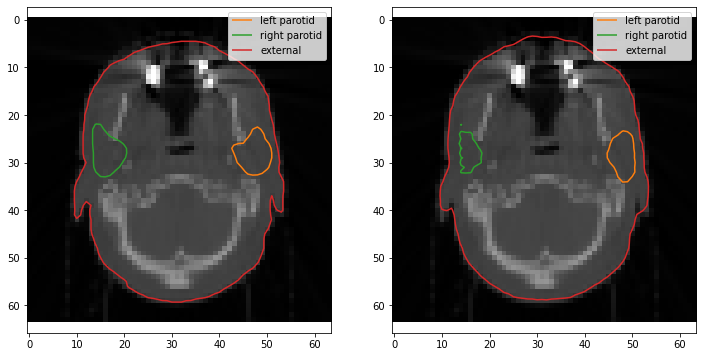


Sample Prediction after epoch 45

4/4 [==============================] - 5s 1s/step - loss: 0.0185 - binary_accuracy: 0.9801 - recall: 0.9173 - precision: 0.9949 - val_loss: 0.0194 - val_binary_accuracy: 0.9803 - val_recall: 0.9235 - val_precision: 0.9918
Epoch 46/50
1/1 [==============================] - 0s 20ms/step


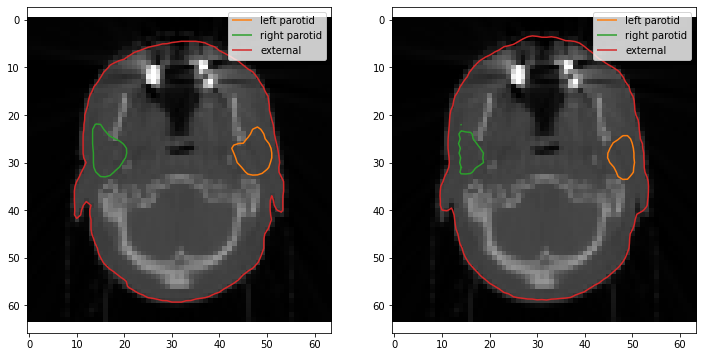


Sample Prediction after epoch 46

4/4 [==============================] - 5s 1s/step - loss: 0.0181 - binary_accuracy: 0.9802 - recall: 0.9206 - precision: 0.9941 - val_loss: 0.0192 - val_binary_accuracy: 0.9804 - val_recall: 0.9238 - val_precision: 0.9927
Epoch 47/50
1/1 [==============================] - 0s 16ms/step


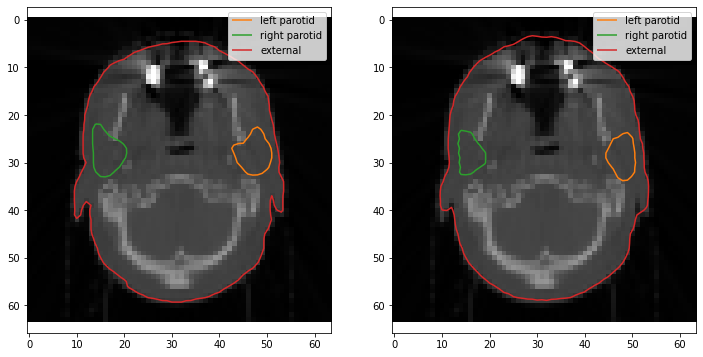


Sample Prediction after epoch 47

4/4 [==============================] - 5s 1s/step - loss: 0.0177 - binary_accuracy: 0.9804 - recall: 0.9243 - precision: 0.9936 - val_loss: 0.0188 - val_binary_accuracy: 0.9805 - val_recall: 0.9269 - val_precision: 0.9913
Epoch 48/50
1/1 [==============================] - 0s 16ms/step


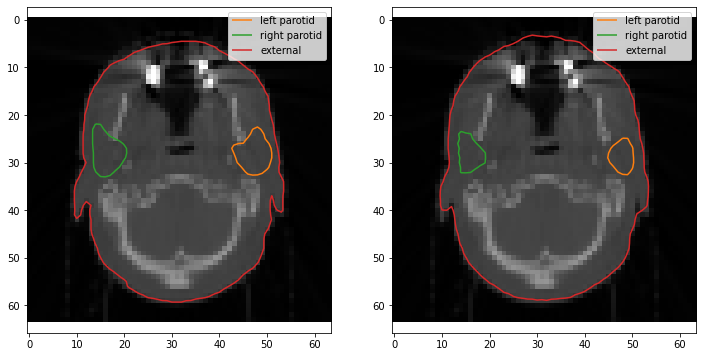


Sample Prediction after epoch 48

4/4 [==============================] - 5s 1s/step - loss: 0.0174 - binary_accuracy: 0.9805 - recall: 0.9264 - precision: 0.9929 - val_loss: 0.0191 - val_binary_accuracy: 0.9805 - val_recall: 0.9204 - val_precision: 0.9943
Epoch 49/50
1/1 [==============================] - 0s 18ms/step


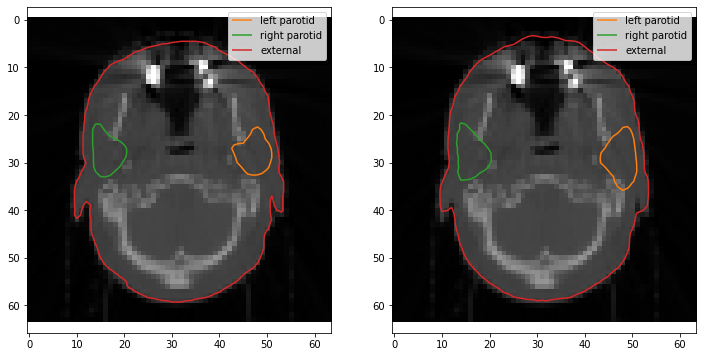


Sample Prediction after epoch 49

4/4 [==============================] - 5s 1s/step - loss: 0.0176 - binary_accuracy: 0.9804 - recall: 0.9258 - precision: 0.9927 - val_loss: 0.0191 - val_binary_accuracy: 0.9800 - val_recall: 0.9375 - val_precision: 0.9829
Epoch 50/50
1/1 [==============================] - 0s 18ms/step


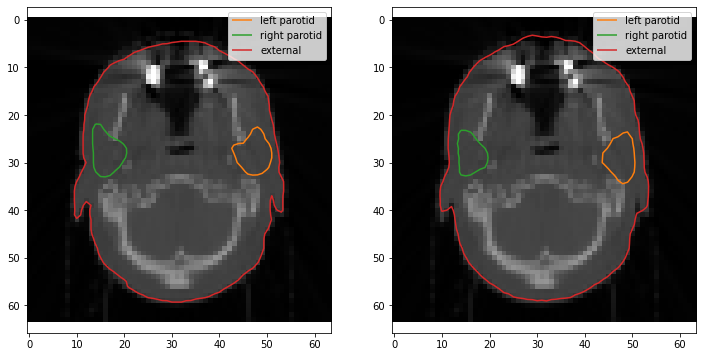


Sample Prediction after epoch 50

4/4 [==============================] - 5s 1s/step - loss: 0.0174 - binary_accuracy: 0.9803 - recall: 0.9282 - precision: 0.9914 - val_loss: 0.0179 - val_binary_accuracy: 0.9807 - val_recall: 0.9300 - val_precision: 0.9904


In [127]:
history = model.fit(
    datasets["training"],
    epochs=50,
    validation_data=datasets["validation"],
    callbacks=[callback],
)

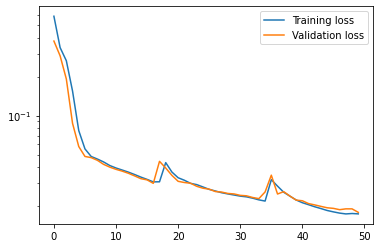

In [128]:
plt.semilogy(history.history["loss"], label="Training loss")
plt.semilogy(
    history.history["val_loss"],
    label="Validation loss",
)
plt.legend()